# Analysis of the MIMIC-III Dataset

In [2]:
from data import configure_db, upload_db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text

# NOTE: currently working with the demo data. make sure to upload to the full data when available!

def preprocessing(query):
    engine = configure_db()
    return pd.read_sql(query, con = engine)

## Introduction

[insert information about the dataset]

### What are the age and gender distributions of patients admitted to the ICU?

  gender  age      los  death_days                             death_time  \
0      F   71   1.6325         283  death not within 90 days of discharge   
1      F   36  13.8507           0                  death within hospital   
2      F   13   2.6499           0                  death within hospital   
3      F   76   2.1436        1196  death not within 90 days of discharge   
4      M   48   1.2938           0                  death within hospital   

   hospital_expire_flag  
0                     0  
1                     1  
2                     1  
3                     0  
4                     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                371 non-null    object 
 1   age                   371 non-null    int64  
 2   los                   371 non-null    float64
 3   death_days       

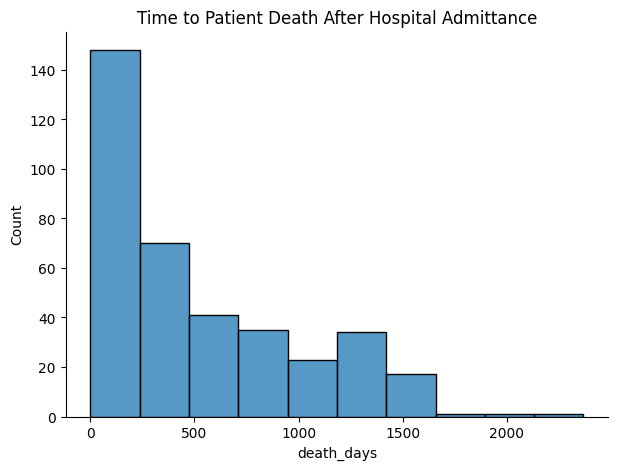

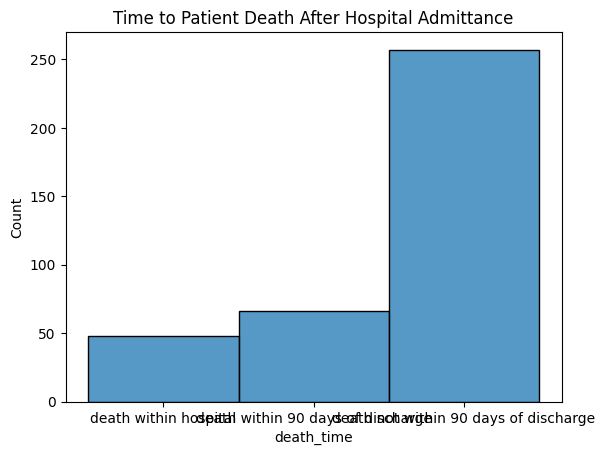

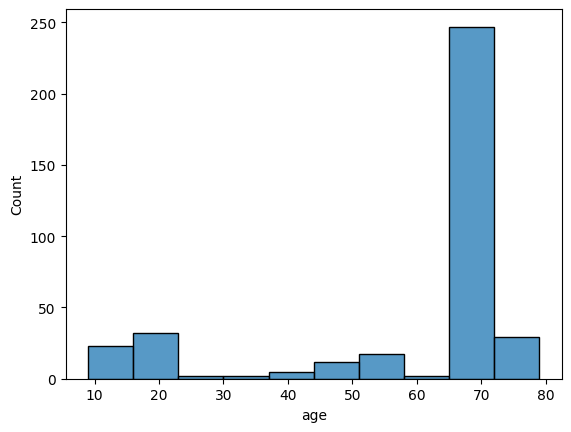

count    371.000000
mean      57.574124
std       18.849382
min        9.000000
25%       57.000000
50%       66.000000
75%       66.000000
max       79.000000
Name: age, dtype: float64


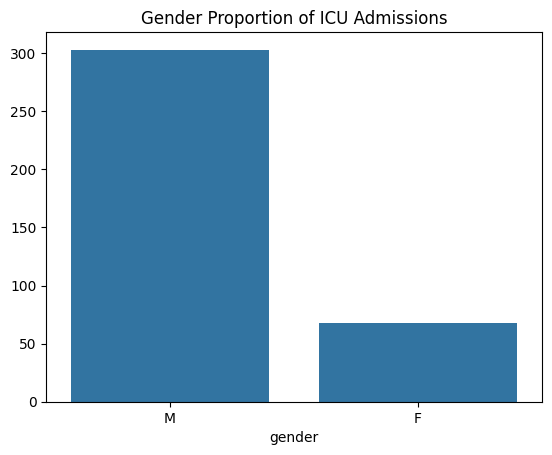

count     371
unique      2
top         M
freq      303
Name: gender, dtype: object


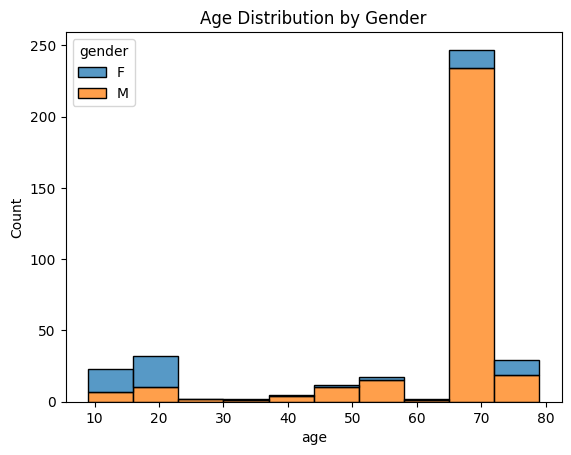

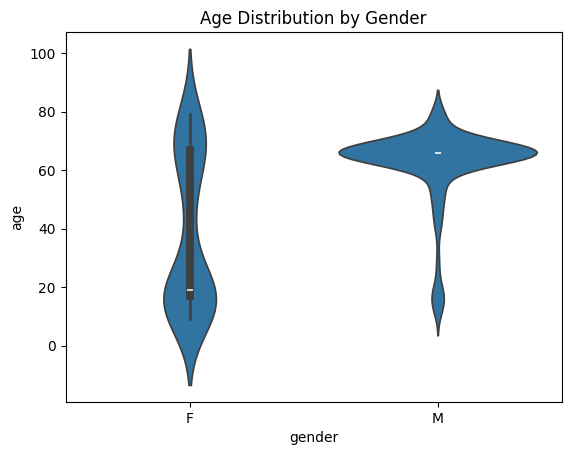

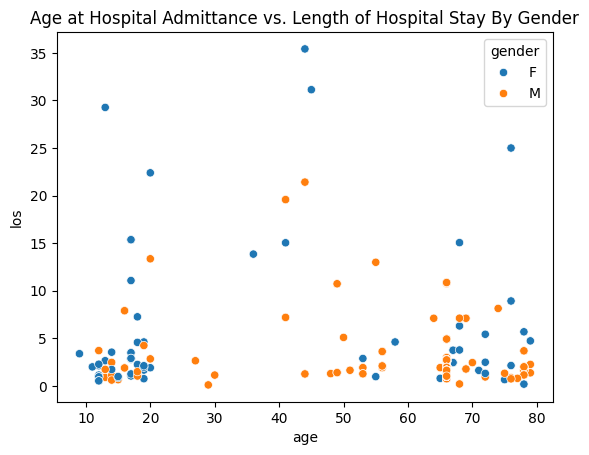

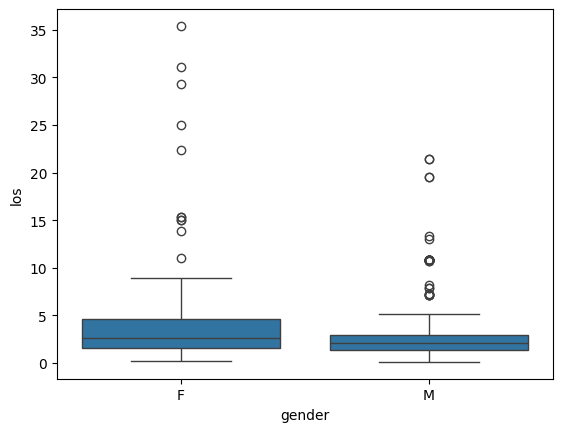

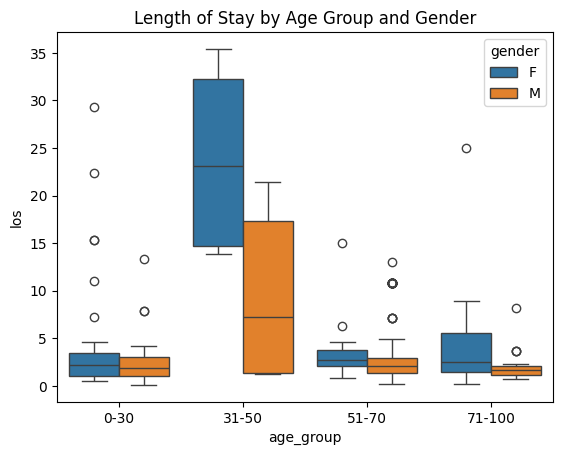

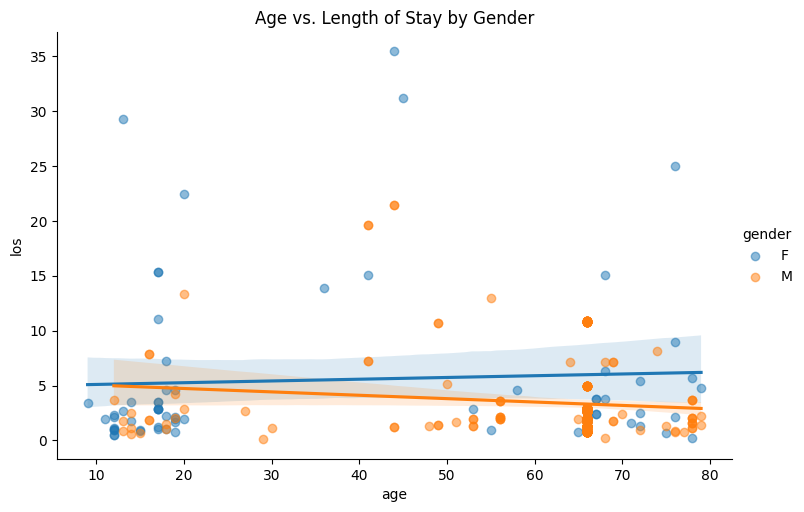

In [3]:
query_a = text("""
            SELECT
                p.gender,
                TIMESTAMPDIFF(YEAR, p.dob, p.dod) AS age,
                i.los,
                ABS(TIMESTAMPDIFF(DAY, p.dod, a.dischtime)) AS death_days,
                IF(ABS(TIMESTAMPDIFF(DAY, p.dod, a.dischtime)) > 90, "death not within 90 days of discharge",
                    IF(TIMESTAMPDIFF(DAY, p.dod, a.dischtime) = 0, "death within hospital",
                        "death within 90 days of discharge")) AS death_time,
                a.hospital_expire_flag
            FROM
                patients AS p
            INNER JOIN
                icustays AS i   
                ON p.subject_id = i.subject_id
            INNER JOIN
                admissions AS a
                ON p.subject_id = a.subject_id
            WHERE 
               TIMESTAMPDIFF(YEAR, p.dob, p.dod) < 300;
        """)

df_a = preprocessing(query_a)
df_a['age'] = df_a['age'].apply(lambda x: 100 - x if x > 79 else x)

print(df_a.head())
df_a.info()

f, ax = plt.subplots(figsize = (7,5))
sns.despine(f)

sns.histplot(df_a['death_days'], bins=10)
plt.title('Time to Patient Death After Hospital Admittance')
plt.show()

df_a['death_time'] = pd.Categorical(df_a['death_time'], categories=["death within hospital", "death within 90 days of discharge", "death not within 90 days of discharge"], ordered=True)
sns.histplot(df_a['death_time'])
plt.title('Time to Patient Death After Hospital Admittance')
plt.show()

sns.histplot(df_a['age'], bins=10)
plt.show()

print(df_a['age'].describe())

gender_counts = df_a['gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title('Gender Proportion of ICU Admissions')
plt.show()

print(df_a['gender'].describe())

sns.histplot(data=df_a, x='age', hue='gender', multiple='stack', bins=10)
plt.title('Age Distribution by Gender')
plt.show()
sns.violinplot(x='gender', y='age', data=df_a)
plt.title('Age Distribution by Gender')
plt.show()

sns.scatterplot(x='age', y='los', hue = df_a['gender'], data=df_a)
plt.title('Age at Hospital Admittance vs. Length of Hospital Stay By Gender')
plt.show()

sns.boxplot(x='gender', y='los', data=df_a)
plt.show()

df_a['age_group'] = pd.cut(df_a['age'], bins=[0, 30, 50, 70, 100], labels=['0-30', '31-50', '51-70', '71-100'])
sns.boxplot(x='age_group', y='los', hue='gender', data=df_a)
plt.title('Length of Stay by Age Group and Gender')
plt.show()

sns.lmplot(x='age', y='los', hue='gender', data=df_a, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Age vs. Length of Stay by Gender')
plt.show()

### What are the demographics of patients admited to the ICU?
### What are the diagnoses of patients admitted to the ICU?
### What are the most common admission diagnoses for different age groups?

In [4]:
query_b = text("""
            SELECT
                p.gender,
                TIMESTAMPDIFF(YEAR, p.dob, p.dod) AS age,
                a.insurance,
                a.religion,
                a.marital_status,
                a.ethnicity,
                a.diagnosis,
                i.los,
                ABS(TIMESTAMPDIFF(DAY, p.dod, a.dischtime)) AS death_days,
                IF(ABS(TIMESTAMPDIFF(DAY, p.dod, a.dischtime)) > 90, "death not within 90 days of discharge", IF(TIMESTAMPDIFF(DAY, p.dod, a.dischtime) = 0, "death within hospital", "death within 90 days of discharge")) AS death_time,
                a.hospital_expire_flag
            FROM
                admissions AS a
            INNER JOIN
                patients AS p
                ON a.subject_id = p.subject_id
            INNER JOIN
                icustays AS i
                ON a.subject_id = i.subject_id;
        """)
df_b = preprocessing(query_b)
#sns.heatmap(df_b, axis=1).corr())


### How do patient outcomes vary by season or time of admission?
### Are there any seaonsal trends in specific diagnoses?

In [5]:
query_c = text("""
            SELECT
                a.admittime,
                a.insurance,
                a.religion,
                a.marital_status,
                a.ethnicity,
                a.diagnosis
            FROM
                admissions AS a;
        """)
df_c = preprocessing(query_c)

### How does the timing of antibiotic administration affect sepsis outcomes?
### How does the type of mediciation administered affect sepsis outcomes?

In [6]:
query_d = text("""
            SELECT
                a.admittime,
                a.dischtime,
                a.hospital_expire_flag,
                c.charttime,
                c.storetime,
                c.value,
                c.valuenum,
                c.valueuom,
                d.label,
                d.abbreviation,
                d.category,
                d.unitname,
                m.spec_itemid,
                m.spec_type_desc,
                m.org_itemid,
                m.org_name,
                m.ab_itemid,
                m.ab_name,
                m.interpretation
            FROM
                admissions AS a
            INNER JOIN
                chartevents AS c
                ON a.hadm_id = c.hadm_id
            INNER JOIN
                microbiologyevents AS m
                ON a.hadm_id = m.hadm_id
            INNER JOIN
                d_items AS d
                ON c.itemid = d.itemid
            WHERE
                LOWER(a.diagnosis) LIKE '%sepsis%';
        """)
df_d = preprocessing(query_d)

### What key features identify a patient as being high risk for readmission?

In [7]:
query_e = text("""
            SELECT
                p.subject_id,
                p.gender,
                TIMESTAMPDIFF(YEAR, p.dob, a.admittime) AS age,
                a.hadm_id,
                a.admission_type,
                a.admittime,
                a.dischtime,
                a.hospital_expire_flag,
                a.diagnosis,
                i.los,
                s.curr_service,
                t.eventtype AS transfer_type,
                t.intime AS transfer_intime,
                t.outtime AS transfer_outtime,
                (SELECT COUNT(*)
                FROM admissions AS a2
                WHERE a2.subject_id = p.subject_id
                AND a2.admittime > a.dischtime
                AND TIMESTAMPDIFF(DAY, a.dischtime, a2.admittime) <= 30) AS readmission_within_30_days
            FROM
                patients AS p
            INNER JOIN
                admissions AS a
                ON p.subject_id = a.subject_id
            INNER JOIN
                icustays AS i
                ON a.hadm_id = i.hadm_id
            INNER JOIN
                services AS s
                ON a.hadm_id = s.hadm_id
            LEFT JOIN
                transfers AS t
                ON a.hadm_id = t.hadm_id
            WHERE
                a.hospital_expire_flag = 0;
        """)
df_e = preprocessing(query_e)